In [ ]:
import pathlib
import elasticdeform

import imgaug.augmenters as iaa
import matplotlib.pyplot as plt
import numpy as np

from PIL import Image
from imgaug.augmentables.segmaps import SegmentationMapsOnImage

ModuleNotFoundError: ignored

### Find image tuples

In [ ]:
def find_images(path):
    images = [f for f in path.iterdir() if f.suffix == '.bmp' and 'anno' not in f.name]
    images_tuple = []
    for image in images:
        annotation = [f for f in path.iterdir() if f.name == f"{image.stem}_anno.bmp"][0]
        images_tuple.append((image, annotation))
    return images_tuple

In [ ]:
input_path = pathlib.Path('./Warwick_dataset')
img_seg_tuple = find_images(input_path)

### Padding and Resizing

In [ ]:
INP_DIM = (522, 775)  # Max width and height of input images - for padding
OUT_DIM = (512, 512)  # Img width and height of output images - for resizing

In [ ]:
def norm_dimensions(img):
    width = max(INP_DIM) - img.shape[0]
    height = max(INP_DIM) - img.shape[1]
    width_plus = 0
    height_plus = 0
    if width % 2 == 1:
        width_plus =+ 1
    if height % 2 == 1:
        height_plus =+ 1
    pad_width = (width // 2, (width // 2) + width_plus)
    pad_height = (height // 2, (height // 2) + height_plus)
    pad_channel = (0, 0)
    if len(img.shape) < 3:
        img = np.pad(img, pad_width=(pad_width, pad_height), mode='constant')
    else:
        img = np.pad(img, pad_width=(pad_width, pad_height, pad_channel), mode='constant')
    img = Image.fromarray(img)
    img = img.resize(OUT_DIM)
    return img

In [ ]:
# Testing

# for img_path, seg_path in img_seg_tuple:
#     img = plt.imread(str(img_path))
#     seg = plt.imread(str(seg_path))
#     img = norm_dimensions(img)
#     seg = norm_dimensions(seg)
#     img.save(f"./Warwick_dataset_pad/{img_path.name}")
#     seg.save(f"./Warwick_dataset_pad/{seg_path.name}")

### Augmentations

In [ ]:
AUG_PER_IMG = 5

sharpen_or_blur = iaa.OneOf([
    # preserves edges unlike gaussian
    iaa.MedianBlur(k=(1, 3)),
    iaa.Sharpen(alpha=(0.25, 1.0), lightness=(0.75, 1.5))
])

seq = iaa.Sequential([
    iaa.Sometimes(0.5, iaa.CropAndPad(percent=(-0.25, 0), keep_size=False)),
    iaa.Fliplr(0.5),
    iaa.Flipud(0.5),
    iaa.Sometimes(0.5, iaa.Rotate((-90, 90))),
    iaa.Sometimes(1, iaa.ElasticTransformation(alpha=(5, 10), sigma=3)),
    iaa.Sometimes(0.2, iaa.AdditiveGaussianNoise(loc=0, scale=(0.01*255, 0.03*255), per_channel=0.5)),
    iaa.Sometimes(0.2, sharpen_or_blur),
])

In [ ]:
input_path = pathlib.Path('./Warwick_dataset')
output_path = pathlib.Path('./Warwick_dataset_aug')
img_seg_tuple = find_images(input_path)

PATHS = [img[0] for img in img_seg_tuple]
IMAGES = [plt.imread(str(img_seg[0])) for img_seg in img_seg_tuple]
SEGMAPS = [plt.imread(str(img_seg[1])) for img_seg in img_seg_tuple]
SEGMAPS_AUG = [SegmentationMapsOnImage(seg, shape=seg.shape) for seg in SEGMAPS]

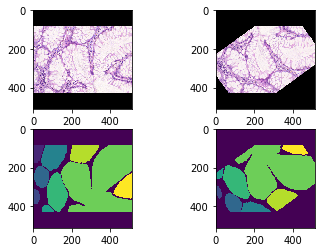

In [ ]:
# Testing

# INDEX = 0
# images_aug, segmaps_aug = seq(images=IMAGES, segmentation_maps=SEGMAPS_AUG)
# orig_img, orig_seg = norm_dimensions(IMAGES[INDEX]), norm_dimensions(SEGMAPS[INDEX])
# aug_img, aug_seg = norm_dimensions(images_aug[INDEX]), norm_dimensions(segmaps_aug[INDEX].get_arr())

# fig, ax = plt.subplots(2, 2)
# ax[0, 0].imshow(np.asarray(orig_img))
# ax[1, 0].imshow(np.asarray(orig_seg))
# ax[0, 1].imshow(np.asarray(aug_img))
# ax[1, 1].imshow(np.asarray(aug_seg))

### Save Augmentations, Padding and Rescaling

In [ ]:
# Normalize and save input data
for img, seg, img_path in zip(IMAGES, SEGMAPS, PATHS):
    img = norm_dimensions(img)
    seg = norm_dimensions(seg)
    img.save(str(output_path / f"{img_path.stem}.bmp"))
    seg.save(str(output_path / f"{img_path.stem}_anno.bmp"))

# Augment, Normalize and save augmented data
for index in range(AUG_PER_IMG):
    images_aug, segmaps_aug = seq(images=IMAGES, segmentation_maps=SEGMAPS_AUG)
    for aug_img, aug_seg, img_path in zip(images_aug, segmaps_aug, PATHS):
        aug_img = norm_dimensions(aug_img)
        aug_seg = norm_dimensions(aug_seg.get_arr())
        aug_img.save(str(output_path / f"{img_path.stem}_{index}.bmp"))
        aug_seg.save(str(output_path / f"{img_path.stem}_{index}_anno.bmp"))

In [1]:
import fdtd

ModuleNotFoundError: ignored